Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.models import model_from_json
from keras.layers import Dropout
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data load

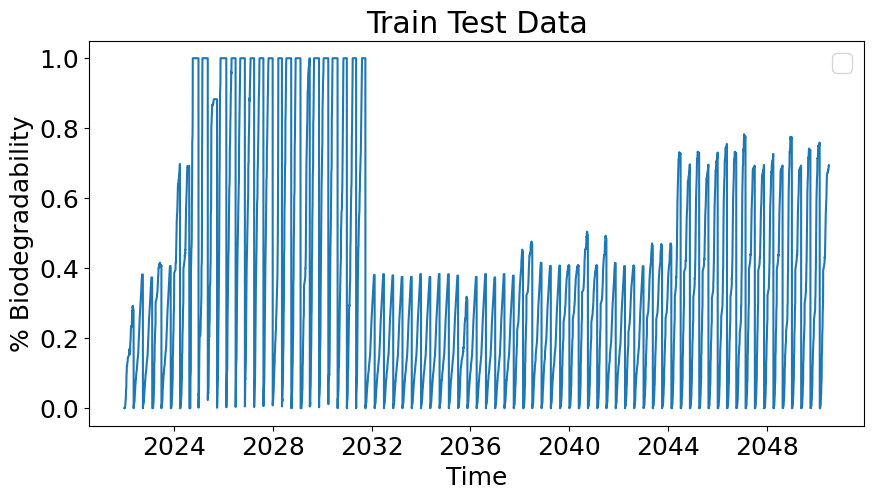

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/PD/Data_Sample_Serie_Values.csv',index_col='Day',parse_dates=True)
df_train.index.freq = 'D'

train = df_train.iloc[:,0:1]

scaled_train = train.values

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})
plt.ylabel('% Biodegradability')
plt.xlabel('Time')
plt.plot(train)
plt.title('Train Test Data')
plt.legend(loc='best')
plt.show()


Data organization

In [3]:
forecasters = []
real = []
length = 10
batch_size_v = 15
j=0


for i in range(length, len(df_train)):
    j=j+1
    if j < 117:
        real.append(scaled_train[i, 0])
        forecasters.append(scaled_train[i-length:i, 0])
    if j == 137:
        j=0

forecasters, real = np.array(forecasters), np.array(real)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))



Model create

In [4]:
model = Sequential()
model.add(LSTM(30, activation='sigmoid', return_sequences = True, input_shape=(length,scaled_train.shape[1])))
model.add(LSTM(60, activation='sigmoid', input_shape=(length,scaled_train.shape[1])))
model.add(Dense(scaled_train.shape[1], activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 60)                21840     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 25741 (100.55 KB)
Trainable params: 25741 (100.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Training

In [5]:
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', min_delta = 1e-10, patience=8)

model_trained = model.fit(forecasters, real, epochs = 100, batch_size = batch_size_v, callbacks=[early_stop], validation_data = (forecasters, real))

model.save('my_rnn_modelserie2022_2.h5')

Epoch 1/100
588/588 [==============================] - 52s 48ms/step - loss: 0.0367 - val_loss: 0.0028
Epoch 2/100
588/588 [==============================] - 17s 28ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/100
588/588 [==============================] - 15s 26ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/100
588/588 [==============================] - 13s 22ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/100
588/588 [==============================] - 16s 27ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/100
588/588 [==============================] - 16s 27ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/100
588/588 [==============================] - 13s 22ms/step - loss: 9.2742e-04 - val_loss: 7.1181e-04
Epoch 8/100
588/588 [==============================] - 9s 16ms/step - loss: 6.9428e-04 - val_loss: 6.1277e-04
Epoch 9/100
588/588 [==============================] - 10s 16ms/step - loss: 6.2733e-04 - val_loss: 7.8613e-04
Epoch 10/100
588/588 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Load de model

In [6]:
model = keras.models.load_model('/content/drive/MyDrive/PD/model_saved.h5')

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10, 30)            3840      
                                                                 
 lstm_29 (LSTM)              (None, 60)                21840     
                                                                 
 dense_14 (Dense)            (None, 1)                 61        
                                                                 
Total params: 25741 (100.55 KB)
Trainable params: 25741 (100.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Loss curve avaliation

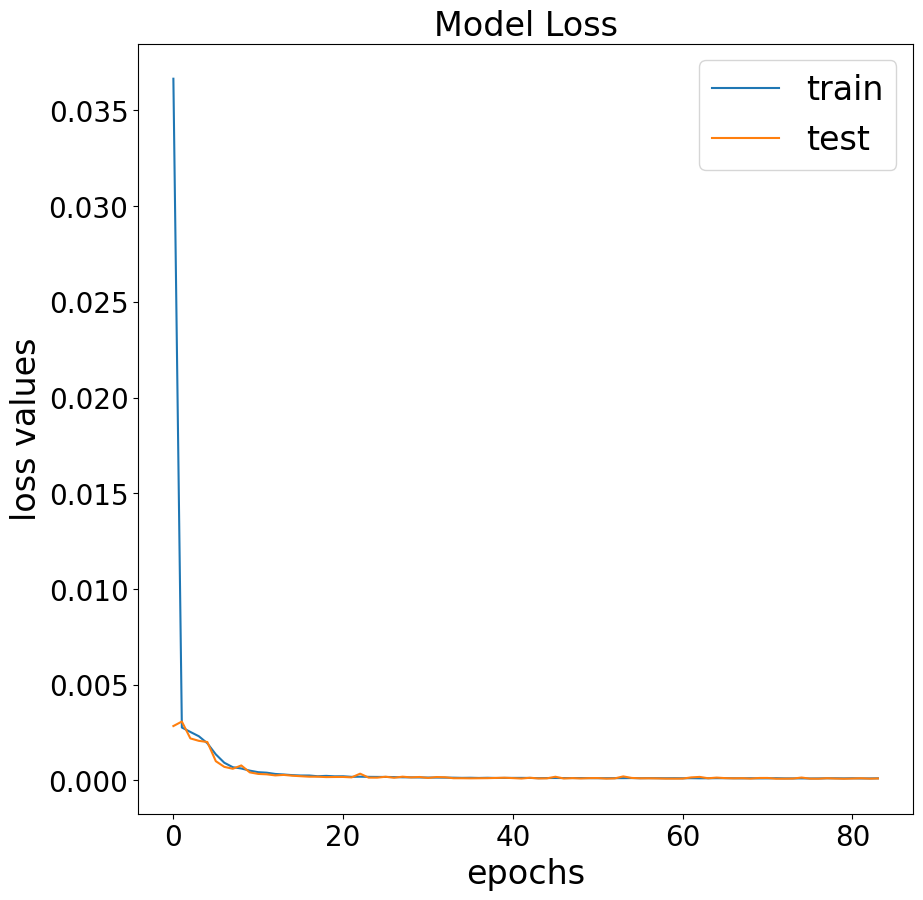

In [7]:
plt.figure(figsize=(10,10))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.plot(model_trained.history['loss'], label='train')
plt.plot(model_trained.history['val_loss'], label='test')
plt.title('Model Loss', fontsize=24)
plt.xlabel('epochs', fontsize=24)
plt.ylabel('loss values', fontsize=24)
plt.legend(loc='upper right', fontsize=24)
plt.show()


Model test - Predict the data for 40%, 80% and 100% of biodegradability

Accuracy calculation functions

In [8]:
def calculate_mae(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def calculate_rms(y_true, y_pred):
    rms = np.sqrt(np.mean(y_true ** 2))
    return rms

def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

30 Days test

1/1 [==============================] - 0s 26ms/step

Sample with 40% biodegradability to forecast 30 days
MAE: 0.015103273414080012
MSE: 0.00029703937772240964
RMSE: 0.01723483036535056
MAPE: 6.688123971068498


Sample with 100% biodegradability to forecast 30 days
MAE: 0.03823802316284434
MSE: 0.002115157166613577
RMSE: 0.04599083785509432
MAPE: 4.944975693167241


Sample with 80% biodegradability to forecast 30 days
MAE: 0.15978665788875387
MSE: 0.03252580911027003
RMSE: 0.18034913116028597
MAPE: 19.28158126295595



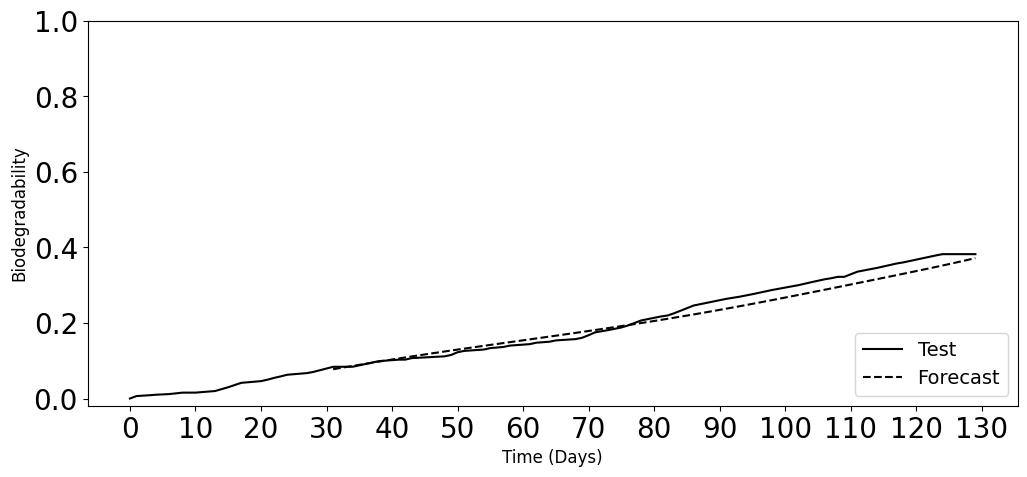

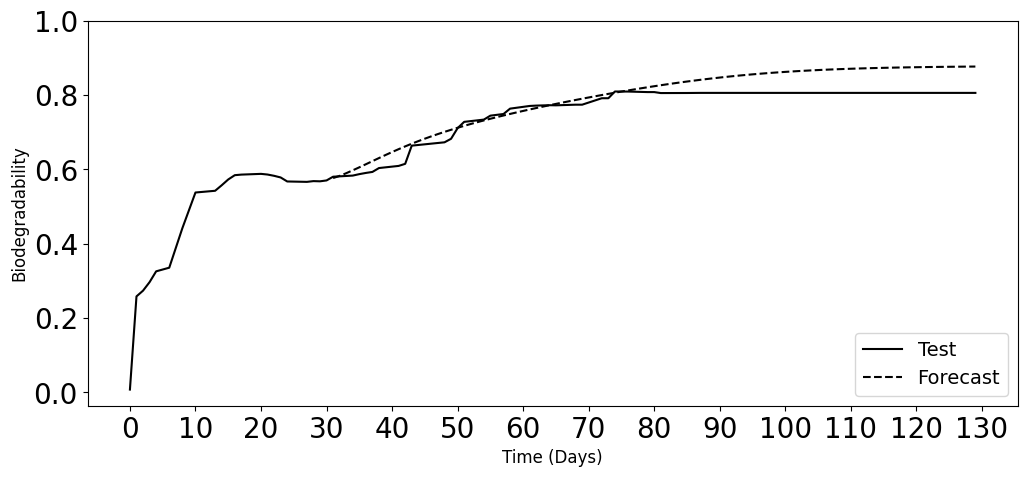

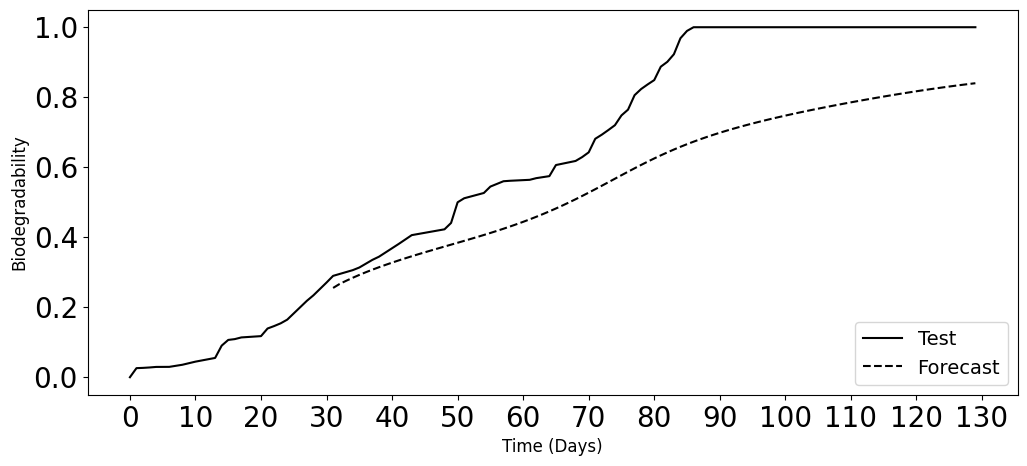

In [9]:
df2 = pd.read_csv('/content/drive/MyDrive/PD/Sample_40bio.csv',index_col='Dias',parse_dates=True)
df2.index.freq = 'D'

df3 = pd.read_csv('/content/drive/MyDrive/PD/Sample_80bio.csv',index_col='Dias',parse_dates=True)
df3.index.freq = 'D'

df4 = pd.read_csv('/content/drive/MyDrive/PD/Sample_100bio.csv',index_col='Dias',parse_dates=True)
df4.index.freq = 'D'


start_day = 30

train2 = df2.iloc[0:start_day,0:1]
test2 = df2.iloc[start_day:,0:1]
scaled_train2 = train2.values
scaled_test2 = test2.values


train3 = df3.iloc[0:start_day,0:1]
test3 = df3.iloc[start_day:,0:1]
scaled_train3 = train3.values
scaled_test3 = test3.values


train4 = df4.iloc[0:start_day,0:1]
test4 = df4.iloc[start_day:,0:1]
scaled_train4 = train4.values
scaled_test4 = test4.values


# define generator
length2 = 10 # Length of the output sequences (in number of timesteps)
batch_size2 = 1 #Number of timeseries samples in each batch

length3 = 10 # Length of the output sequences (in number of timesteps)
batch_size3 = 1 #Number of timeseries samples in each batch

length4 = 10 # Length of the output sequences (in number of timesteps)
batch_size4 = 1 #Number of timeseries samples in each batch

test_predictions2 = []
first_eval_batch2 = scaled_train2[-length2:]
current_batch2 = first_eval_batch2.reshape((1, length2, batch_size2))


test_predictions3 = []
first_eval_batch3 = scaled_train3[-length3:]
current_batch3 = first_eval_batch3.reshape((1, length3, batch_size3))


test_predictions4 = []
first_eval_batch4 = scaled_train4[-length4:]
current_batch4 = first_eval_batch4.reshape((1, length4, batch_size4))


for i in range(len(test2)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred2 = model.predict(current_batch2)[0]

    # store prediction
    test_predictions2.append(current_pred2)

    # update batch to now include prediction and drop first value
    current_batch2 = np.append(current_batch2[:,1:,:],[[current_pred2]],axis=1)


for i in range(len(test3)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred3 = model.predict(current_batch3)[0]

    # store prediction
    test_predictions3.append(current_pred3)

    # update batch to now include prediction and drop first value
    current_batch3 = np.append(current_batch3[:,1:,:],[[current_pred3]],axis=1)


for i in range(len(test4)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred4 = model.predict(current_batch4)[0]

    # store prediction
    test_predictions4.append(current_pred4)

    # update batch to now include prediction and drop first value
    current_batch4 = np.append(current_batch4[:,1:,:],[[current_pred4]],axis=1)


true_predictions2 = test_predictions2

true_predictions3 = test_predictions3

true_predictions4 = test_predictions4


true_predictions2 = pd.DataFrame(data=true_predictions2,columns=test2.columns)

true_predictions3 = pd.DataFrame(data=true_predictions3,columns=test3.columns)

true_predictions4 = pd.DataFrame(data=true_predictions4,columns=test4.columns)


value_test2 = test2.iloc[:,0:0+1].values
value_forecast2 = true_predictions2.iloc[:,0:0+1].values


value_test3 = test3.iloc[:,0:0+1].values
value_forecast3 = true_predictions3.iloc[:,0:0+1].values


value_test4 = test4.iloc[:,0:0+1].values
value_forecast4 = true_predictions4.iloc[:,0:0+1].values


graf2 = df2.iloc[0:130,:].values
graf3 = df3.iloc[0:130,:].values
graf4 = df4.iloc[0:130,:].values


seq = list(range(start_day+1, 130))

grafpred2 = value_forecast2[0:len(seq)]

grafpred3 = value_forecast3[0:len(seq)]

grafpred4 = value_forecast4[0:len(seq)]

plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf2, color='black',label='Train')
plt.plot(seq, grafpred2, '--', color='black', label='predito')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test2[:(len(test2))], value_forecast2)
mse = calculate_mse(value_test2[:(len(test2))], value_forecast2)
rms = calculate_rms(value_test2[:(len(test2))], value_forecast2)
rmse = calculate_rmse(value_test2[:(len(test2))], value_forecast2)
mape = calculate_mape(value_test2[:(len(test2))], value_forecast2)


print("")
print(f"Sample with 40% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf3, color='black',label='Train')
plt.plot(seq, grafpred3, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test3[:(len(test3))], value_forecast3)
mse = calculate_mse(value_test3[:(len(test3))], value_forecast3)
rms = calculate_rms(value_test3[:(len(test3))], value_forecast3)
rmse = calculate_rmse(value_test3[:(len(test3))], value_forecast3)
mape = calculate_mape(value_test3[:(len(test3))], value_forecast3)


print("")
print(f"Sample with 100% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf4, color='black',label='Train')
plt.plot(seq, grafpred4, '--', color='black', label='predito')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test4[:(len(test4))], value_forecast4)
mse = calculate_mse(value_test4[:(len(test4))], value_forecast4)
rms = calculate_rms(value_test4[:(len(test4))], value_forecast4)
rmse = calculate_rmse(value_test4[:(len(test4))], value_forecast4)
mape = calculate_mape(value_test4[:(len(test4))], value_forecast4)



print("")
print(f"Sample with 80% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


40 days test

1/1 [==============================] - 0s 46ms/step

Sample with 40% biodegradability to forecast 40 days
MAE: 0.01697540994431964
MSE: 0.0003758452812283304
RMSE: 0.019386729513466948
MAPE: 6.925355653336595


Sample with 100% biodegradability to forecast 40 days
MAE: 0.03701217207439134
MSE: 0.001978187024708218
RMSE: 0.04447681446223659
MAPE: 4.6662781133003834


Sample with 80% biodegradability to forecast 40 days
MAE: 0.12694812224421376
MSE: 0.02299444435514448
RMSE: 0.15163919135614143
MAPE: 13.773620138152992



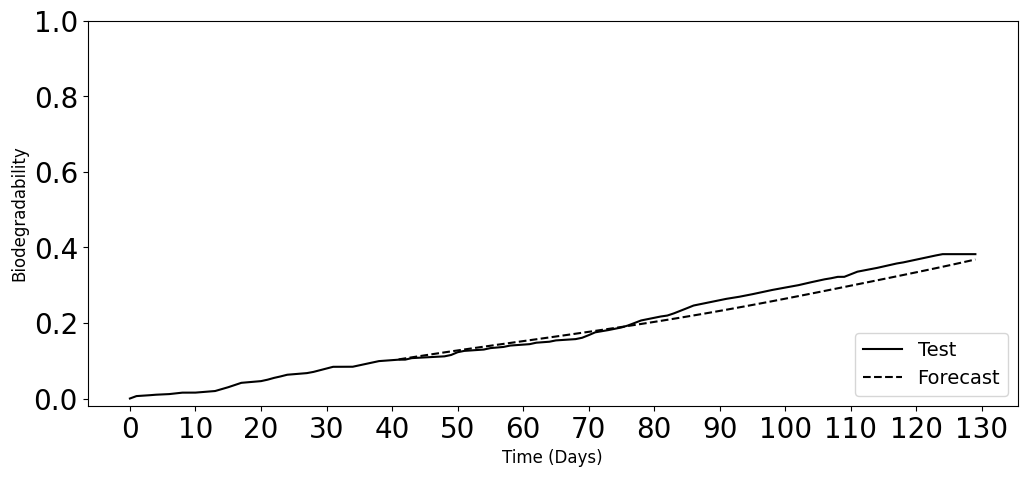

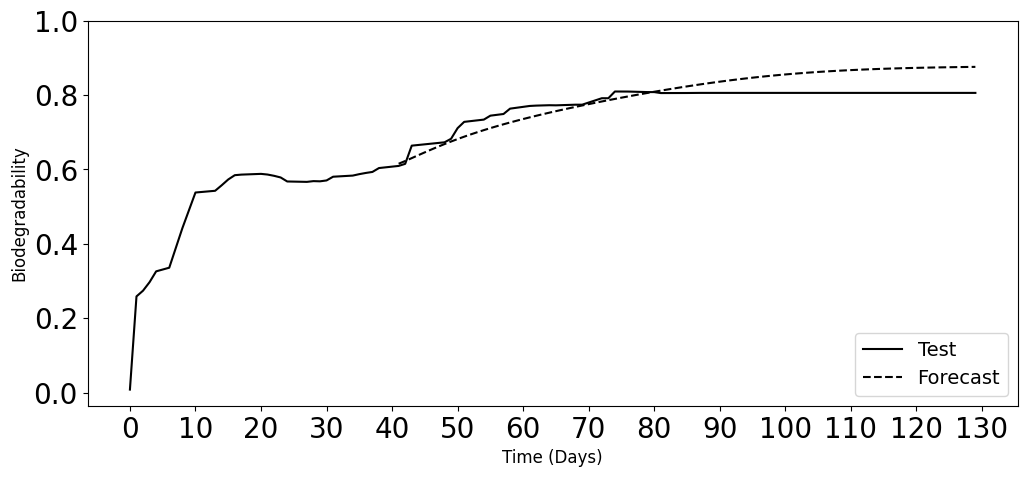

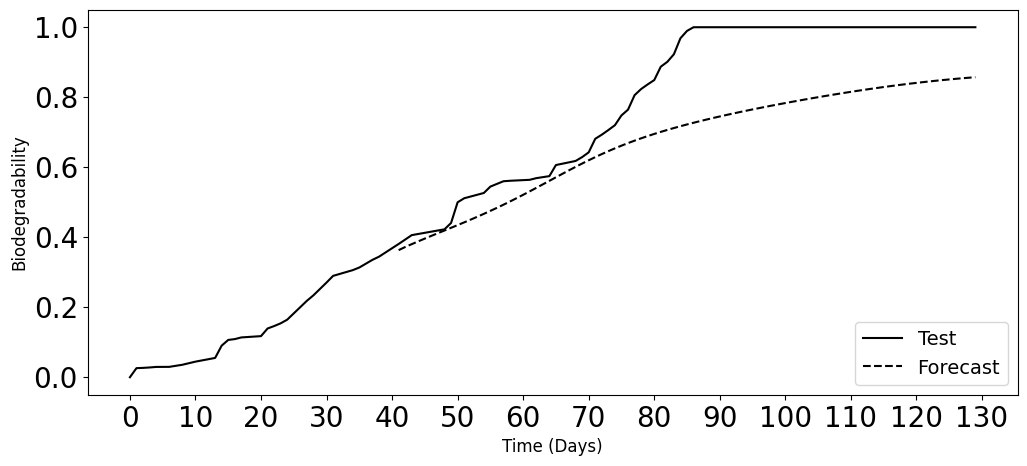

In [10]:
df2 = pd.read_csv('/content/drive/MyDrive/PD/Sample_40bio.csv',index_col='Dias',parse_dates=True)
df2.index.freq = 'D'

df3 = pd.read_csv('/content/drive/MyDrive/PD/Sample_80bio.csv',index_col='Dias',parse_dates=True)
df3.index.freq = 'D'

df4 = pd.read_csv('/content/drive/MyDrive/PD/Sample_100bio.csv',index_col='Dias',parse_dates=True)
df4.index.freq = 'D'


start_day = 40

train2 = df2.iloc[0:start_day,0:1]
test2 = df2.iloc[start_day:,0:1]
scaled_train2 = train2.values
scaled_test2 = test2.values


train3 = df3.iloc[0:start_day,0:1]
test3 = df3.iloc[start_day:,0:1]
scaled_train3 = train3.values
scaled_test3 = test3.values


train4 = df4.iloc[0:start_day,0:1]
test4 = df4.iloc[start_day:,0:1]
scaled_train4 = train4.values
scaled_test4 = test4.values


# define generator
length2 = 10 # Length of the output sequences (in number of timesteps)
batch_size2 = 1 #Number of timeseries samples in each batch

length3 = 10 # Length of the output sequences (in number of timesteps)
batch_size3 = 1 #Number of timeseries samples in each batch

length4 = 10 # Length of the output sequences (in number of timesteps)
batch_size4 = 1 #Number of timeseries samples in each batch

test_predictions2 = []
first_eval_batch2 = scaled_train2[-length2:]
current_batch2 = first_eval_batch2.reshape((1, length2, batch_size2))


test_predictions3 = []
first_eval_batch3 = scaled_train3[-length3:]
current_batch3 = first_eval_batch3.reshape((1, length3, batch_size3))


test_predictions4 = []
first_eval_batch4 = scaled_train4[-length4:]
current_batch4 = first_eval_batch4.reshape((1, length4, batch_size4))


for i in range(len(test2)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred2 = model.predict(current_batch2)[0]

    # store prediction
    test_predictions2.append(current_pred2)

    # update batch to now include prediction and drop first value
    current_batch2 = np.append(current_batch2[:,1:,:],[[current_pred2]],axis=1)


for i in range(len(test3)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred3 = model.predict(current_batch3)[0]

    # store prediction
    test_predictions3.append(current_pred3)

    # update batch to now include prediction and drop first value
    current_batch3 = np.append(current_batch3[:,1:,:],[[current_pred3]],axis=1)


for i in range(len(test4)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred4 = model.predict(current_batch4)[0]

    # store prediction
    test_predictions4.append(current_pred4)

    # update batch to now include prediction and drop first value
    current_batch4 = np.append(current_batch4[:,1:,:],[[current_pred4]],axis=1)


true_predictions2 = test_predictions2

true_predictions3 = test_predictions3

true_predictions4 = test_predictions4


true_predictions2 = pd.DataFrame(data=true_predictions2,columns=test2.columns)

true_predictions3 = pd.DataFrame(data=true_predictions3,columns=test3.columns)

true_predictions4 = pd.DataFrame(data=true_predictions4,columns=test4.columns)


value_test2 = test2.iloc[:,0:0+1].values
value_forecast2 = true_predictions2.iloc[:,0:0+1].values


value_test3 = test3.iloc[:,0:0+1].values
value_forecast3 = true_predictions3.iloc[:,0:0+1].values


value_test4 = test4.iloc[:,0:0+1].values
value_forecast4 = true_predictions4.iloc[:,0:0+1].values


graf2 = df2.iloc[0:130,:].values
graf3 = df3.iloc[0:130,:].values
graf4 = df4.iloc[0:130,:].values


seq = list(range(start_day+1, 130))

grafpred2 = value_forecast2[0:len(seq)]

grafpred3 = value_forecast3[0:len(seq)]

grafpred4 = value_forecast4[0:len(seq)]

plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf2, color='black',label='Train')
plt.plot(seq, grafpred2, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test2[:(len(test2))], value_forecast2)
mse = calculate_mse(value_test2[:(len(test2))], value_forecast2)
rms = calculate_rms(value_test2[:(len(test2))], value_forecast2)
rmse = calculate_rmse(value_test2[:(len(test2))], value_forecast2)
mape = calculate_mape(value_test2[:(len(test2))], value_forecast2)


print("")
print(f"Sample with 40% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf3, color='black',label='Train')
plt.plot(seq, grafpred3, '--', color='black', label='predito')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test3[:(len(test3))], value_forecast3)
mse = calculate_mse(value_test3[:(len(test3))], value_forecast3)
rms = calculate_rms(value_test3[:(len(test3))], value_forecast3)
rmse = calculate_rmse(value_test3[:(len(test3))], value_forecast3)
mape = calculate_mape(value_test3[:(len(test3))], value_forecast3)


print("")
print(f"Sample with 100% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf4, color='black',label='Train')
plt.plot(seq, grafpred4, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test4[:(len(test4))], value_forecast4)
mse = calculate_mse(value_test4[:(len(test4))], value_forecast4)
rms = calculate_rms(value_test4[:(len(test4))], value_forecast4)
rmse = calculate_rmse(value_test4[:(len(test4))], value_forecast4)
mape = calculate_mape(value_test4[:(len(test4))], value_forecast4)



print("")
print(f"Sample with 80% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


50 Days test

1/1 [==============================] - 0s 25ms/step

Sample with 40% biodegradability to forecast 50 days
MAE: 0.02530513855008787
MSE: 0.0009553881564643484
RMSE: 0.030909353866820775
MAPE: 8.60042741917299


Sample with 100% biodegradability to forecast 50 days
MAE: 0.040064562115223724
MSE: 0.0021818637035694254
RMSE: 0.04671042392838482
MAPE: 5.016279450103041


Sample with 80% biodegradability to forecast 50 days
MAE: 0.14113661979858697
MSE: 0.025755207755924516
RMSE: 0.1604842913057989
MAPE: 15.193562000233635



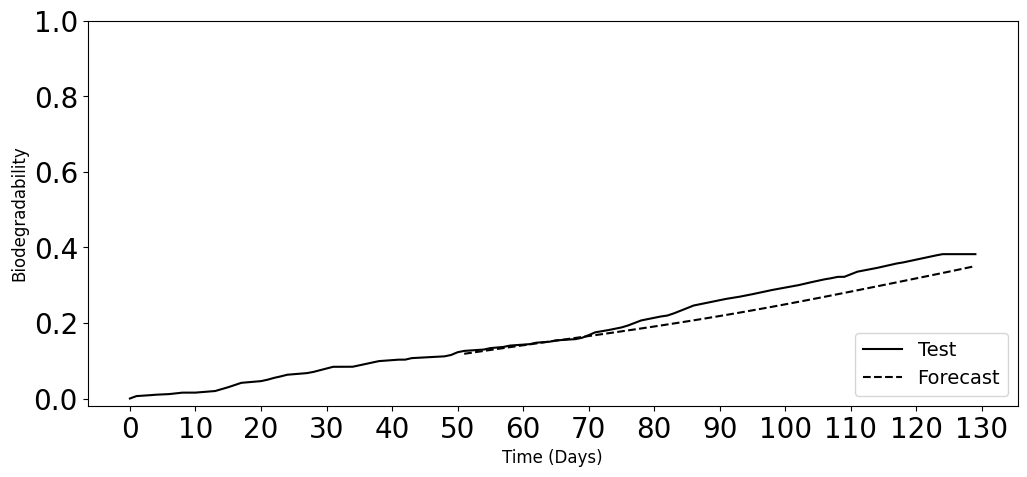

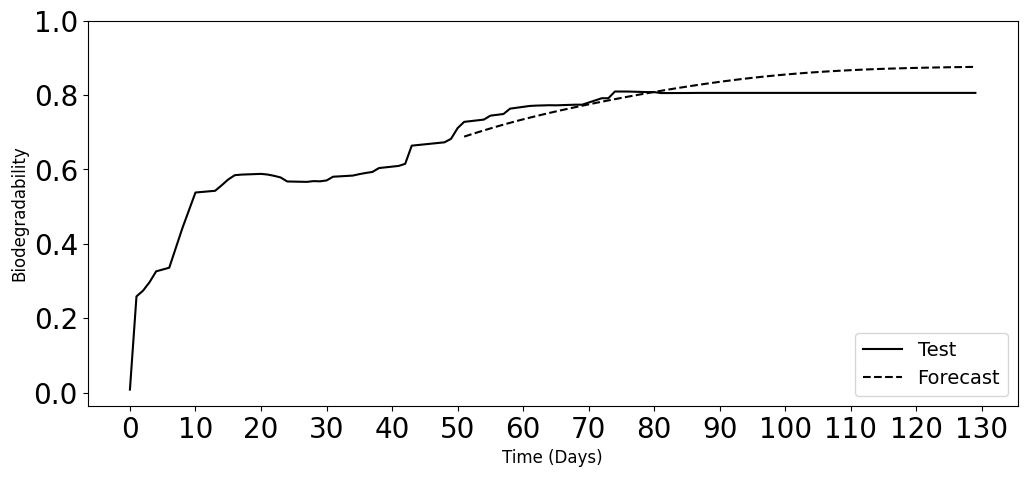

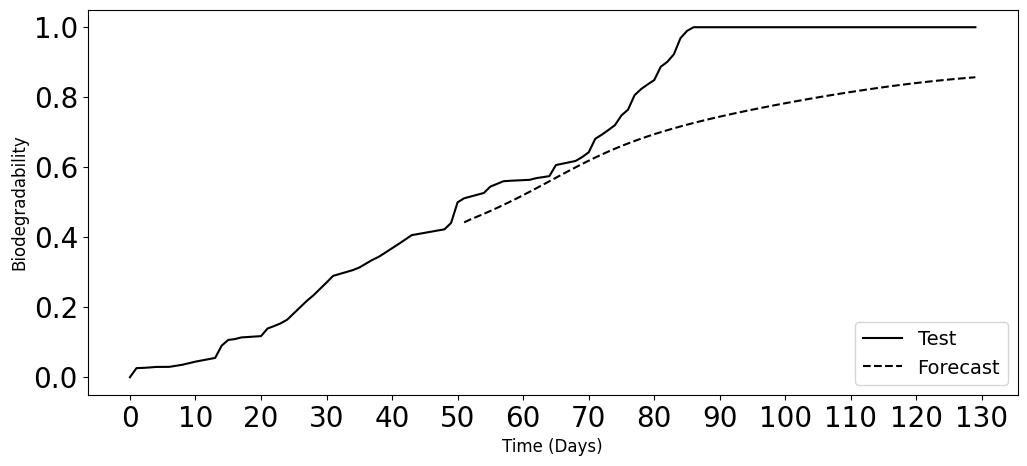

In [11]:
df2 = pd.read_csv('/content/drive/MyDrive/PD/Sample_40bio.csv',index_col='Dias',parse_dates=True)
df2.index.freq = 'D'

df3 = pd.read_csv('/content/drive/MyDrive/PD/Sample_80bio.csv',index_col='Dias',parse_dates=True)
df3.index.freq = 'D'

df4 = pd.read_csv('/content/drive/MyDrive/PD/Sample_100bio.csv',index_col='Dias',parse_dates=True)
df4.index.freq = 'D'


start_day = 50

train2 = df2.iloc[0:start_day,0:1]
test2 = df2.iloc[start_day:,0:1]
scaled_train2 = train2.values
scaled_test2 = test2.values


train3 = df3.iloc[0:start_day,0:1]
test3 = df3.iloc[start_day:,0:1]
scaled_train3 = train3.values
scaled_test3 = test3.values


train4 = df4.iloc[0:start_day,0:1]
test4 = df4.iloc[start_day:,0:1]
scaled_train4 = train4.values
scaled_test4 = test4.values


# define generator
length2 = 10 # Length of the output sequences (in number of timesteps)
batch_size2 = 1 #Number of timeseries samples in each batch

length3 = 10 # Length of the output sequences (in number of timesteps)
batch_size3 = 1 #Number of timeseries samples in each batch

length4 = 10 # Length of the output sequences (in number of timesteps)
batch_size4 = 1 #Number of timeseries samples in each batch

test_predictions2 = []
first_eval_batch2 = scaled_train2[-length2:]
current_batch2 = first_eval_batch2.reshape((1, length2, batch_size2))


test_predictions3 = []
first_eval_batch3 = scaled_train3[-length3:]
current_batch3 = first_eval_batch3.reshape((1, length3, batch_size3))


test_predictions4 = []
first_eval_batch4 = scaled_train4[-length4:]
current_batch4 = first_eval_batch4.reshape((1, length4, batch_size4))


for i in range(len(test2)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred2 = model.predict(current_batch2)[0]

    # store prediction
    test_predictions2.append(current_pred2)

    # update batch to now include prediction and drop first value
    current_batch2 = np.append(current_batch2[:,1:,:],[[current_pred2]],axis=1)


for i in range(len(test3)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred3 = model.predict(current_batch3)[0]

    # store prediction
    test_predictions3.append(current_pred3)

    # update batch to now include prediction and drop first value
    current_batch3 = np.append(current_batch3[:,1:,:],[[current_pred3]],axis=1)


for i in range(len(test4)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred4 = model.predict(current_batch4)[0]

    # store prediction
    test_predictions4.append(current_pred4)

    # update batch to now include prediction and drop first value
    current_batch4 = np.append(current_batch4[:,1:,:],[[current_pred4]],axis=1)


true_predictions2 = test_predictions2

true_predictions3 = test_predictions3

true_predictions4 = test_predictions4


true_predictions2 = pd.DataFrame(data=true_predictions2,columns=test2.columns)

true_predictions3 = pd.DataFrame(data=true_predictions3,columns=test3.columns)

true_predictions4 = pd.DataFrame(data=true_predictions4,columns=test4.columns)


value_test2 = test2.iloc[:,0:0+1].values
value_forecast2 = true_predictions2.iloc[:,0:0+1].values


value_test3 = test3.iloc[:,0:0+1].values
value_forecast3 = true_predictions3.iloc[:,0:0+1].values


value_test4 = test4.iloc[:,0:0+1].values
value_forecast4 = true_predictions4.iloc[:,0:0+1].values


graf2 = df2.iloc[0:130,:].values
graf3 = df3.iloc[0:130,:].values
graf4 = df4.iloc[0:130,:].values


seq = list(range(start_day+1, 130))

grafpred2 = value_forecast2[0:len(seq)]

grafpred3 = value_forecast3[0:len(seq)]

grafpred4 = value_forecast4[0:len(seq)]

plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf2, color='black',label='Train')
plt.plot(seq, grafpred2, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test2[:(len(test2))], value_forecast2)
mse = calculate_mse(value_test2[:(len(test2))], value_forecast2)
rms = calculate_rms(value_test2[:(len(test2))], value_forecast2)
rmse = calculate_rmse(value_test2[:(len(test2))], value_forecast2)
mape = calculate_mape(value_test2[:(len(test2))], value_forecast2)


print("")
print(f"Sample with 40% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf3, color='black',label='Train')
plt.plot(seq, grafpred3, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test3[:(len(test3))], value_forecast3)
mse = calculate_mse(value_test3[:(len(test3))], value_forecast3)
rms = calculate_rms(value_test3[:(len(test3))], value_forecast3)
rmse = calculate_rmse(value_test3[:(len(test3))], value_forecast3)
mape = calculate_mape(value_test3[:(len(test3))], value_forecast3)


print("")
print(f"Sample with 100% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf4, color='black',label='Train')
plt.plot(seq, grafpred4, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test4[:(len(test4))], value_forecast4)
mse = calculate_mse(value_test4[:(len(test4))], value_forecast4)
rms = calculate_rms(value_test4[:(len(test4))], value_forecast4)
rmse = calculate_rmse(value_test4[:(len(test4))], value_forecast4)
mape = calculate_mape(value_test4[:(len(test4))], value_forecast4)



print("")
print(f"Sample with 80% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


60 Days test

1/1 [==============================] - 0s 23ms/step

Sample with 40% biodegradability to forecast 60 days
MAE: 0.027472819671589578
MSE: 0.0010155038572669986
RMSE: 0.031866971259707104
MAPE: 9.24162024899185


Sample with 100% biodegradability to forecast 60 days
MAE: 0.04768259216120283
MSE: 0.0028234362485741525
RMSE: 0.053136016491398305
MAPE: 5.927529451534124


Sample with 80% biodegradability to forecast 60 days
MAE: 0.14228503410745122
MSE: 0.02532137639091176
RMSE: 0.15912691912719154
MAPE: 14.738880471210617



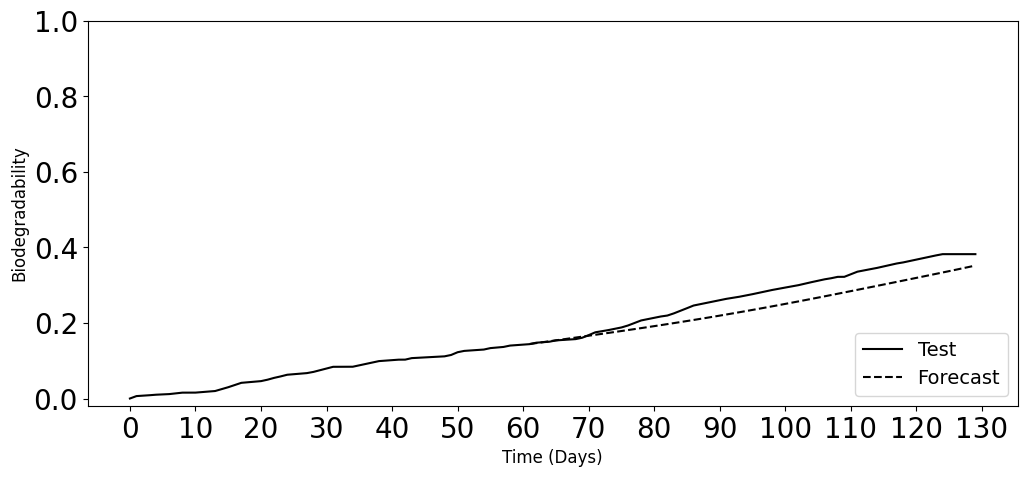

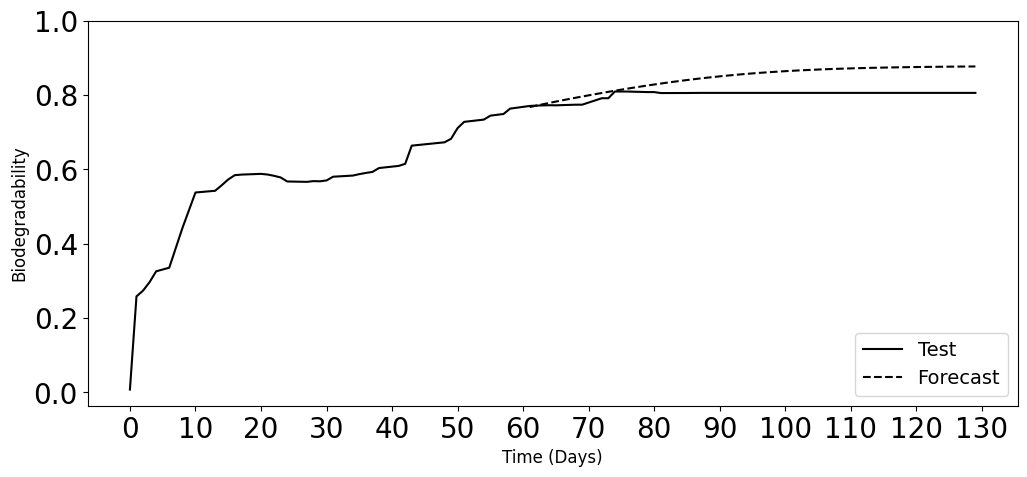

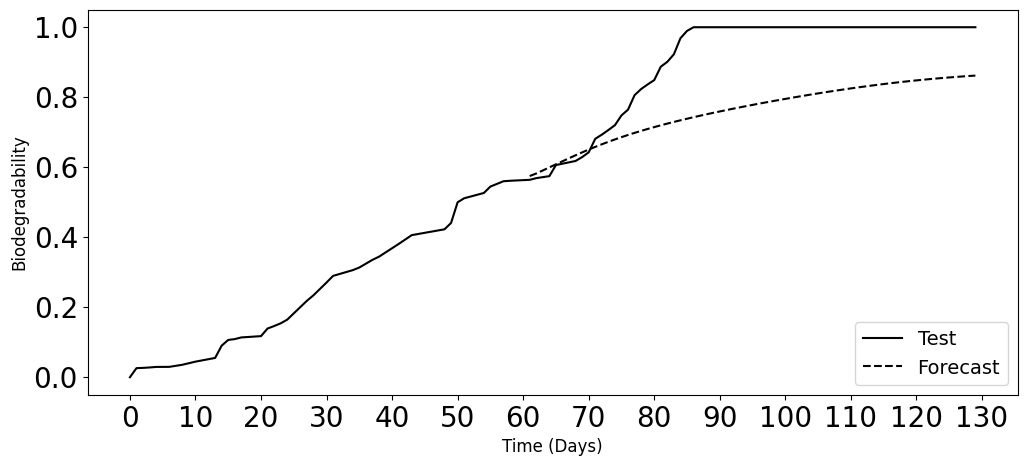

In [12]:
df2 = pd.read_csv('/content/drive/MyDrive/PD/Sample_40bio.csv',index_col='Dias',parse_dates=True)
df2.index.freq = 'D'

df3 = pd.read_csv('/content/drive/MyDrive/PD/Sample_80bio.csv',index_col='Dias',parse_dates=True)
df3.index.freq = 'D'

df4 = pd.read_csv('/content/drive/MyDrive/PD/Sample_100bio.csv',index_col='Dias',parse_dates=True)
df4.index.freq = 'D'


start_day = 60

train2 = df2.iloc[0:start_day,0:1]
test2 = df2.iloc[start_day:,0:1]
scaled_train2 = train2.values
scaled_test2 = test2.values


train3 = df3.iloc[0:start_day,0:1]
test3 = df3.iloc[start_day:,0:1]
scaled_train3 = train3.values
scaled_test3 = test3.values


train4 = df4.iloc[0:start_day,0:1]
test4 = df4.iloc[start_day:,0:1]
scaled_train4 = train4.values
scaled_test4 = test4.values


# define generator
length2 = 10 # Length of the output sequences (in number of timesteps)
batch_size2 = 1 #Number of timeseries samples in each batch

length3 = 10 # Length of the output sequences (in number of timesteps)
batch_size3 = 1 #Number of timeseries samples in each batch

length4 = 10 # Length of the output sequences (in number of timesteps)
batch_size4 = 1 #Number of timeseries samples in each batch

test_predictions2 = []
first_eval_batch2 = scaled_train2[-length2:]
current_batch2 = first_eval_batch2.reshape((1, length2, batch_size2))


test_predictions3 = []
first_eval_batch3 = scaled_train3[-length3:]
current_batch3 = first_eval_batch3.reshape((1, length3, batch_size3))


test_predictions4 = []
first_eval_batch4 = scaled_train4[-length4:]
current_batch4 = first_eval_batch4.reshape((1, length4, batch_size4))


for i in range(len(test2)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred2 = model.predict(current_batch2)[0]

    # store prediction
    test_predictions2.append(current_pred2)

    # update batch to now include prediction and drop first value
    current_batch2 = np.append(current_batch2[:,1:,:],[[current_pred2]],axis=1)


for i in range(len(test3)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred3 = model.predict(current_batch3)[0]

    # store prediction
    test_predictions3.append(current_pred3)

    # update batch to now include prediction and drop first value
    current_batch3 = np.append(current_batch3[:,1:,:],[[current_pred3]],axis=1)


for i in range(len(test4)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred4 = model.predict(current_batch4)[0]

    # store prediction
    test_predictions4.append(current_pred4)

    # update batch to now include prediction and drop first value
    current_batch4 = np.append(current_batch4[:,1:,:],[[current_pred4]],axis=1)


true_predictions2 = test_predictions2

true_predictions3 = test_predictions3

true_predictions4 = test_predictions4


true_predictions2 = pd.DataFrame(data=true_predictions2,columns=test2.columns)

true_predictions3 = pd.DataFrame(data=true_predictions3,columns=test3.columns)

true_predictions4 = pd.DataFrame(data=true_predictions4,columns=test4.columns)


value_test2 = test2.iloc[:,0:0+1].values
value_forecast2 = true_predictions2.iloc[:,0:0+1].values


value_test3 = test3.iloc[:,0:0+1].values
value_forecast3 = true_predictions3.iloc[:,0:0+1].values


value_test4 = test4.iloc[:,0:0+1].values
value_forecast4 = true_predictions4.iloc[:,0:0+1].values


graf2 = df2.iloc[0:130,:].values
graf3 = df3.iloc[0:130,:].values
graf4 = df4.iloc[0:130,:].values


seq = list(range(start_day+1, 130))

grafpred2 = value_forecast2[0:len(seq)]

grafpred3 = value_forecast3[0:len(seq)]

grafpred4 = value_forecast4[0:len(seq)]

plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf2, color='black',label='Train')
plt.plot(seq, grafpred2, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test2[:(len(test2))], value_forecast2)
mse = calculate_mse(value_test2[:(len(test2))], value_forecast2)
rms = calculate_rms(value_test2[:(len(test2))], value_forecast2)
rmse = calculate_rmse(value_test2[:(len(test2))], value_forecast2)
mape = calculate_mape(value_test2[:(len(test2))], value_forecast2)


print("")
print(f"Sample with 40% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf3, color='black',label='Train')
plt.plot(seq, grafpred3, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test3[:(len(test3))], value_forecast3)
mse = calculate_mse(value_test3[:(len(test3))], value_forecast3)
rms = calculate_rms(value_test3[:(len(test3))], value_forecast3)
rmse = calculate_rmse(value_test3[:(len(test3))], value_forecast3)
mape = calculate_mape(value_test3[:(len(test3))], value_forecast3)


print("")
print(f"Sample with 100% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")


plt.figure(figsize=(12,5), dpi=100)
plt.plot(graf4, color='black',label='Train')
plt.plot(seq, grafpred4, '--', color='black', label='forecast')
plt.legend(['Test', 'Forecast'], loc=4, prop={'size': 14})
plt.ylabel("Biodegradability",  fontsize=12)
plt.xlabel("Time (Days)",  fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # mudar escala do eixo X
plt.xticks([0, 10,20,30,40,50,60,70,80,90,100,110,120,130]) # mudar escala do eixo X

mae = calculate_mae(value_test4[:(len(test4))], value_forecast4)
mse = calculate_mse(value_test4[:(len(test4))], value_forecast4)
rms = calculate_rms(value_test4[:(len(test4))], value_forecast4)
rmse = calculate_rmse(value_test4[:(len(test4))], value_forecast4)
mape = calculate_mape(value_test4[:(len(test4))], value_forecast4)



print("")
print(f"Sample with 80% biodegradability to forecast {start_day} days")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print("")
